In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation du dataframe Fer2013

In [ ]:
fer = pd.read_csv('../content/drive/MyDrive/fer2013.csv')
fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# EDA

In [ ]:
fer.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [ ]:
fer.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
fer.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Visualisation du dataframe en fonction de l'émotion

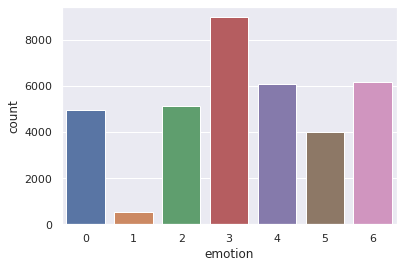

In [ ]:
sns.set_theme(style= "darkgrid")
ax = sns.countplot(x = "emotion", data=fer)

In [ ]:
emotions = {0: 'Colère', 1: 'Dégoût', 2: 'Peur', 3: 'Joie', 4: 'Tristesse', 5: 'Surprise', 6: 'Neutre'}

In [ ]:
emotion_counts = fer['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotions)
emotion_counts

,emotion,number
0,Colère,4953
1,Peur,5121
2,Tristesse,6077
3,Neutre,6198
4,Joie,8989
5,Surprise,4002
6,Dégoût,547


Le dataframe FER2013 présente une grande disparité, mais le dégoût est celle qui présente le volume le plus faible. Pour cela, on décide de scrapper des images dont les visages seront extraits.

Importation de la data augmentation pour le sentiment de dégoût et rajout au dataframe originel

In [ ]:
disgust = pd.read_csv('../content/drive/MyDrive/disgust.csv')
disgust.head()

,emotion,pixels,Usage
0,1,54 51 54 50 55 56 56 53 56 57 57 57 56 59 60 5...,Training
1,1,215 196 133 61 50 47 58 62 61 60 58 59 63 70 7...,Training
2,1,189 187 187 188 189 189 190 180 134 126 118 11...,Training
3,1,49 55 46 41 55 53 42 57 74 75 68 84 83 82 73 8...,Training
4,1,63 47 34 29 29 32 34 32 29 33 36 30 21 30 49 7...,Training


In [ ]:
fer_aug = pd.concat([fer, disgust])
fer_aug.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


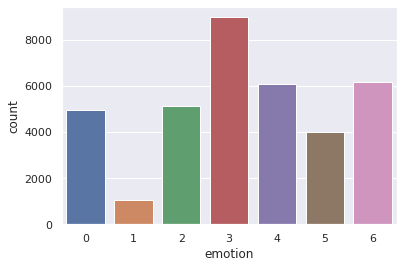

In [ ]:
sns.set_theme(style= "darkgrid")
ax = sns.countplot(x = "emotion", data=fer_aug)

In [ ]:
emotion_counts = fer_aug['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotions)
emotion_counts

,emotion,number
0,Colère,4953
1,Peur,5121
2,Tristesse,6077
3,Neutre,6198
4,Joie,8989
5,Surprise,4002
6,Dégoût,1043


L'ajout de notre dataframe, réalisé à partir de visages d'images scrappées permet de doubler le nombre de visage présent dans la classe dégoût. 

# Préparation des données

In [ ]:
X = fer_aug['pixels']
y = fer_aug['emotion']

In [ ]:
train_set = fer_aug[(fer_aug['Usage'] == 'Training')] 
val_set = fer_aug[(fer_aug['Usage'] == 'PrivateTest')]
test_set = fer_aug[(fer_aug['Usage'] == 'PublicTest')] 

Conversion des chaînes de pixels en matrices de nombres flottants (float32) à trois dimensions (hauteur, largeur, nombre de canaux) pour les utiliser comme entrée du modèle de réseau neuronal convolutif.

In [ ]:
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1) 
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
y_train = train_set.emotion
y_val = val_set.emotion
y_test = test_set.emotion

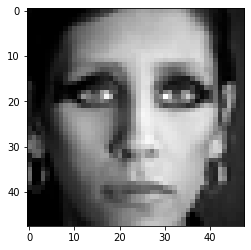

In [ ]:
plt.imshow(X_train[4].reshape(48, 48), cmap = 'gray')

Data augmentation pour le sentiment correpondant au dégoût au même niveau que celui de la surprise.

In [ ]:
# import random

# def add_noise(img):
#     '''Add random noise to an image'''
#     VARIABILITY = 10
#     deviation = VARIABILITY*random.random()
#     noise = np.random.normal(0, deviation, img.shape)
#     img += noise
#     np.clip(img, 0., 255.)
#     return img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(    
    rotation_range=30, # rotation
    width_shift_range=0.2, # déplacement horizontal
    height_shift_range=0.2, # déplacement vertical
    zoom_range=0.2, # zoom
    shear_range=0.2, # distortion
    brightness_range=[0.2, 0.8], # luminosité
    horizontal_flip=True, # inversion horizontale
    fill_mode='nearest',
)

In [ ]:
sentiments = [0, 1, 2, 4, 5, 6]
total_images_required = len(X_train[y_train == 5])

print(f"""Dégoût avant data augmentation: {len(X_train[y_train == 1])}""")
print(f"""X_train: {len(X_train)},y_train: {len(y_train)}""")

for sentiment in sentiments:
    indices = y_train == sentiment
    n_images_current = sum(indices)
    n_images_missing = total_images_required - n_images_current
    if n_images_missing > 0:
        new_images = []
        n_generated = 0
        while n_generated < n_images_missing:
            images = datagen.flow(X_train[indices], batch_size = n_images_missing - n_generated)
            new_images.append(images[0])
            n_generated += images[0].shape[0]
        new_images = np.concatenate(new_images, axis = 0)
        X_train = np.concatenate((X_train, new_images))
        y_train = pd.concat([y_train, pd.Series([sentiment] * new_images.shape[0], dtype = np.float64)], axis = 0)

print(f"""Dégoût après data augmentation: {len(X_train[y_train == 1])}""")
print(f"""X_train: {len(X_train)},y_train: {len(y_train)}""")

Dégoût avant data augmentation: 932
X_train: 29205,y_train: 29205
Dégoût après data augmentation: 3171
X_train: 31444,y_train: 31444


In [ ]:
sentiments = [0, 1, 2, 4, 5, 6]
total_images_required = len(X_val[y_val == 5])

print(f"""X_val: {len(X_val)},y_val: {len(y_val)}""")

for sentiment in sentiments:
    indices = y_val == sentiment
    n_images_current = sum(indices)
    n_images_missing = total_images_required - n_images_current
    if n_images_missing > 0:
        new_images = []
        n_generated = 0
        while n_generated < n_images_missing:
            images = datagen.flow(X_val[indices], batch_size = n_images_missing - n_generated)
            new_images.append(images[0])
            n_generated += images[0].shape[0]
        new_images = np.concatenate(new_images, axis = 0)
        X_val = np.concatenate((X_val, new_images))
        y_val = pd.concat([y_val, pd.Series([sentiment] * new_images.shape[0], dtype = np.float64)], axis = 0)
    
print(f"""X_val: {len(X_val)},y_val: {len(y_val)}""")

X_val: 3589,y_val: 3589
X_val: 3950,y_val: 3950


In [ ]:
print(f"X_train: {X_train.shape}, X_val : {X_val.shape}")

X_train: (50505, 48, 48, 1), X_val : (6153, 48, 48, 1)


In [ ]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [ ]:
print(f"X_train: {X_train.shape}, X_val : {X_val.shape}")

X_train: (31444, 48, 48, 1), X_val : (3950, 48, 48, 1)


Toutes les images présentent dans X_train sont ajoutées à un dataframe qui permet de voir ultérieurement les images générées.

In [ ]:
X_reshape = X_train.reshape(X_train.shape[0], -1) 

In [ ]:
X_reshape.shape

(31444, 2304)

In [ ]:
df = pd.DataFrame(list(zip(X_reshape,y_train)), columns = ['pixels','emotion'])
df.head()

,pixels,emotion
0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",0.0
1,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",0.0
2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",2.0
3,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",4.0
4,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0


In [ ]:
df.to_csv('../content/drive/MyDrive/X_train_augmented2.csv', index=False, encoding='utf-8')

Conversion les étiquettes des classes en vecteurs binaires. cela permet au modèle de prédire la probabilité de chaque classe plutôt que simplement de prédire la classe elle-même.

In [ ]:
from keras.utils import np_utils

In [ ]:
y_train = np_utils.to_categorical(y_train, 7)
y_val = np_utils.to_categorical(y_val, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [ ]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_test.shape

(3589, 7)

Callback

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)
callback = EarlyStopping(monitor='loss', patience=7)

In [ ]:
checkpoint_filepath = '../content/drive/MyDrive/checkpoints'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Réseau neuronal convolutif (CNN)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Input, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, GaussianNoise

In [ ]:
model = Sequential()

# couche 1 de convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# couche 2 de convolution
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# couche 3 de convolution
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Flattening
model.add(Flatten())

# Couche cachée de neurone
model.add(Dense(128))
model.add(GaussianNoise(0.1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
print(f"X_train: {X_train.shape}, X_val : {X_val.shape}")

X_train: (31444, 48, 48, 1), X_val : (3950, 48, 48, 1)


# Entraînement du modèle CNN

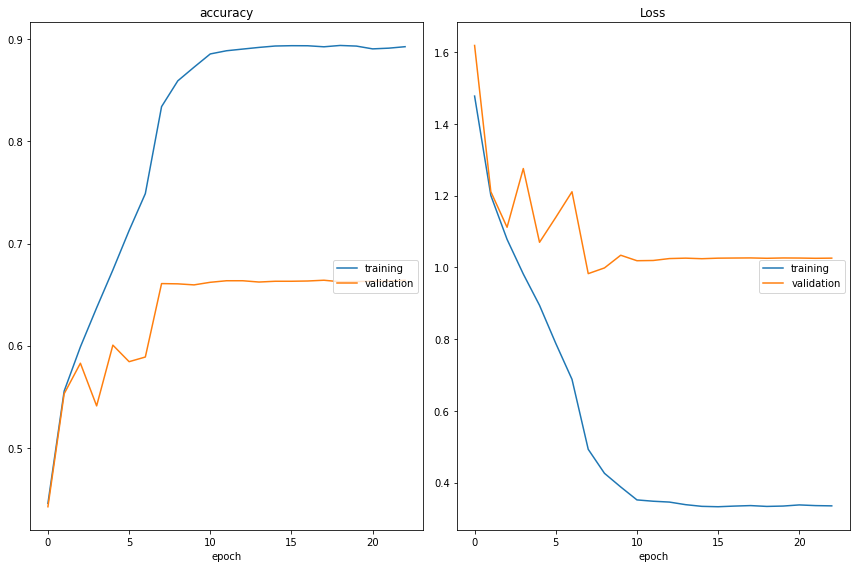

accuracy
	training         	 (min:    0.446, max:    0.894, cur:    0.893)
	validation       	 (min:    0.442, max:    0.664, cur:    0.664)
Loss
	training         	 (min:    0.333, max:    1.478, cur:    0.335)
	validation       	 (min:    0.983, max:    1.619, cur:    1.026)
983/983 [==============================] - 14s 14ms/step - loss: 0.3351 - accuracy: 0.8927 - val_loss: 1.0257 - val_accuracy: 0.6641 - lr: 1.0000e-09


In [ ]:
history = model.fit(X_train, y_train, 
                    callbacks=[PlotLossesKeras(), callback, lr_reduce, model_checkpoint_callback], 
                    validation_data= (X_val, y_val), 
                    # steps_per_epoch = train.n//train.batch_size,
                    # validation_steps = val.n//val.batch_size,
                    epochs = 50)
model.load_weights(checkpoint_filepath)

In [ ]:
# fer_json = model.to_json()  
# with open("../content/drive/MyDrive/fer2.json", "w") as json_file:  
#     json_file.write(fer_json)  
# model.save_weights("../content/drive/MyDrive/fer2.h5") 

Enregistrement du modèle.

In [ ]:
model.save('../content/drive/MyDrive/emotions_augx2-m1-2.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# Matrice de confusion

In [ ]:
y_pred_ = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

113/113 [==============================] - 1s 4ms/step


In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)

    plt.subplots(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

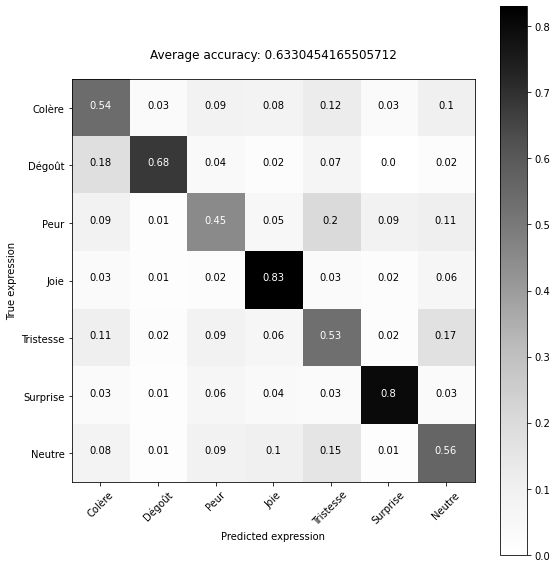

In [ ]:
classes=np.array(("Colère", "Dégoût", "Peur", "Joie", "Tristesse", "Surprise", "Neutre"))
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')